Objective:
1) Implementation of kmeans Clustering in Data Stocks 
2) Visualization of  Kmeans with different columns

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Library Decleration

In [2]:
import os
import glob
import string
import argparse
import pandas as pd 
import numpy as np
from os import listdir
from pickle import dump
from pickle import load
from PIL import Image
from numpy import array
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import preprocess_input
from keras.utils import plot_model
from keras.models import Model
from keras.models import load_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint


#Read and Open File

In [3]:
fn = "/content/drive/My Drive/Dataset/Flickr8k_text/Flickr8k.token.txt"
file = open(fn, 'r')
data = file.read()

#Plot images and desc

In [8]:
#initial desc without cleaning
int_img = list()
datatxt = list()
for line in data.split('\n'):
    col = line.split('\t')
    if len(line) == 0:
        continue
    img = col[0].split("#") 
    datatxt.append(img + [col[1]])
for i in datatxt:
  del i[1]
datatxt
df = pd.DataFrame(datatxt,columns=["image","desc"])
uni_key = np.unique(df.image.values)
uni_key

array(['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg',
       '1002674143_1b742ab4b8.jpg', ..., '99679241_adc853a5c0.jpg',
       '997338199_7343367d7f.jpg', '997722733_0cb5439472.jpg'],
      dtype=object)

#display images and respective captions

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']
['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails sitting in front of a rainbow painting .', 'Young girl with pigtails painting outside

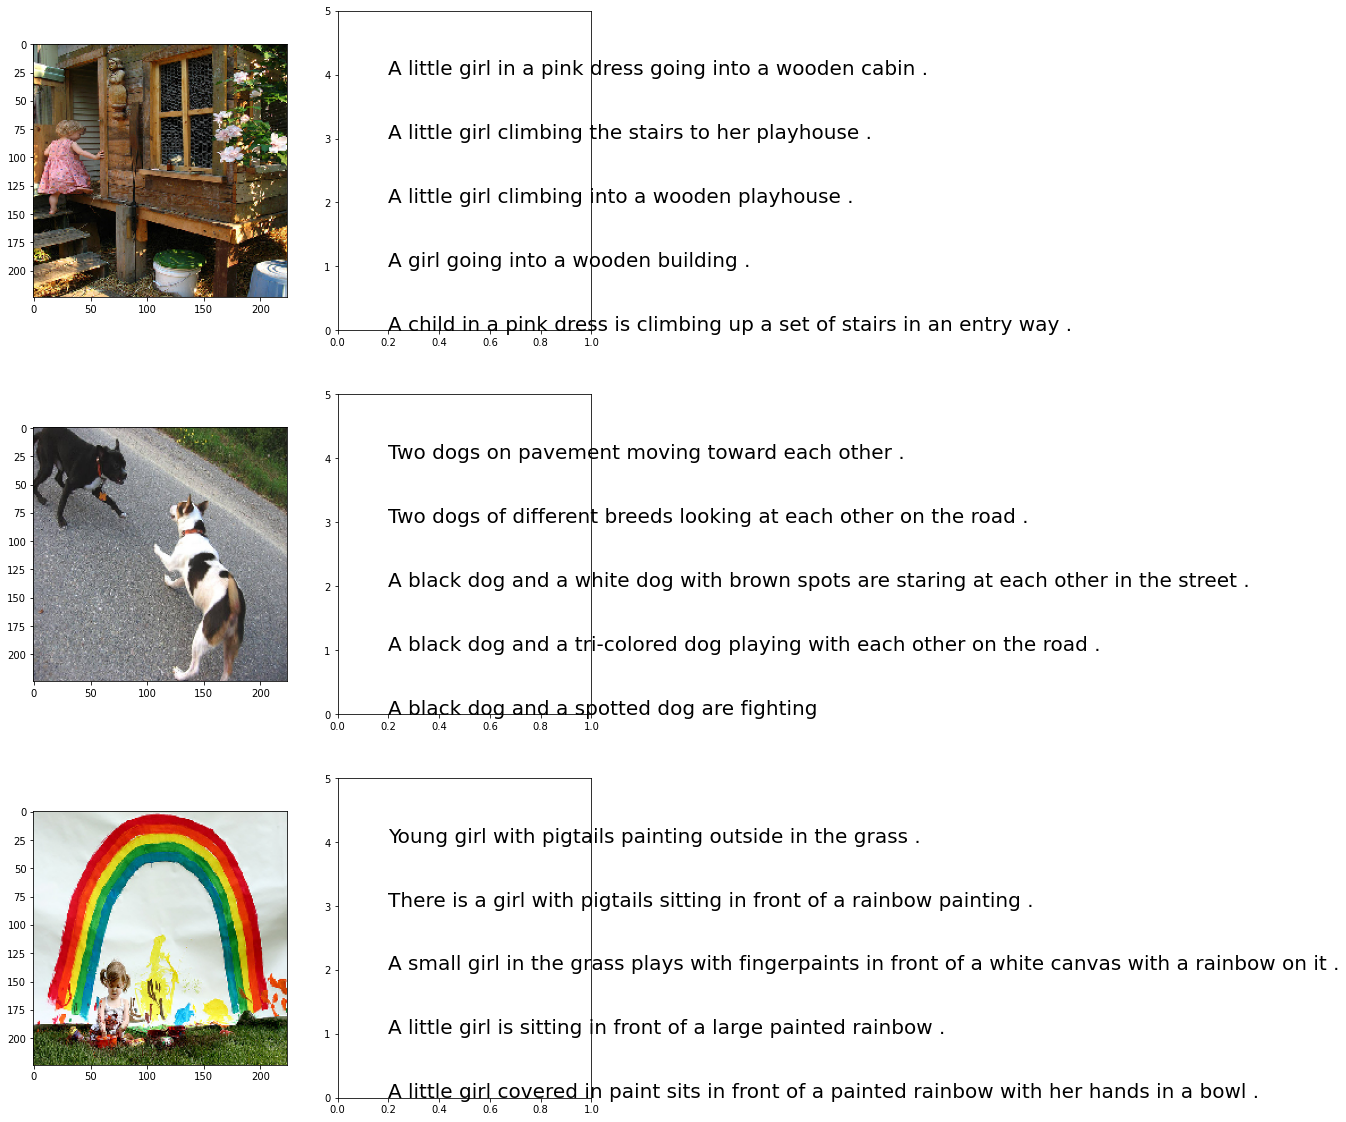

In [15]:
img_direc = "/content/drive/My Drive/Dataset/Flickr8k_Dataset/Flicker8k_Dataset"
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
count = 1
fig = plt.figure(figsize=(10,20))
for img in uni_key[:3]:
    filename = img_direc + '/' + img
    captions = list(df["desc"].loc[df["image"]==img])
    print(captions)
    image_load = load_img(filename, target_size=(224,224,3))
    
    ax = fig.add_subplot(3,2,count)
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(3,2,count)
    plt.axis()
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i,cap in enumerate(captions,start=0):
        ax.text(0.2,i,cap,fontsize=20)
    count += 1
plt.show()

#Seperationg image and captions

In [17]:
#initial desc without cleaning
int_desc = dict()
raw_int_desc=()
for line in data.split('\n'):
  captions = line.split()
  if len(line) == 0:
    continue
  image_name = captions[0]
  image_desc = captions[1:]
  image_name = image_name.split('#')[0]
  image_desc = ' '.join(image_desc)
  if image_name not in int_desc:
    int_desc[image_name] = list()
  int_desc[image_name].append(image_desc)
raw_int_desc= int_desc
raw_int_desc

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

#most frequently and least frequently occure words

In [21]:
from collections import Counter
# Defining a function to calculate the top 3 words in all the captions available for the images
def all_word(int_desc):
    vocabulary = []
    for val in int_desc.values():
        s_val = ' '.join([str(i).lower() for i in val]) 
        vocabulary.extend(s_val.split())
    print("Vocabulary Size:", len(vocabulary))
    #print(vocabulary[2])
    ct = Counter(vocabulary)
    #print(ct.keys())
    #print(ct.values())
    df = {"w":list(ct.keys()),"c":list(ct.values())}
    dfword = pd.DataFrame(df)
    dfword = dfword.sort_values("c",ascending=False)
    dfword = dfword.reset_index()[["w","c"]]
    return(dfword)
allwords = all_word(int_desc)
allwords.head(3)

Vocabulary Size: 476706


,w,c
0,a,62989
1,.,36581
2,in,18975


# Data Cleaning

In [ ]:
#desc after cleaning
trans = str.maketrans('', '', string.punctuation)
for key, value in int_desc.items():
    for i in range(len(value)):
        des = value[i]
        des = des.split()
        des = [i.lower() for i in des]
        des = [i.translate(trans) for i in des]
        des = [i for i in des if len(i)>=2]
        des = [i for i in des if i.isalpha()]
        value[i] =  ' '.join(des)
int_desc

{'1000268201_693b08cb0e.jpg': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70.jpg': ['black dog and spotted dog are fighting',
  'black dog and tricolored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8.jpg': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young 

#plotting

Vocabulary Size: 372935


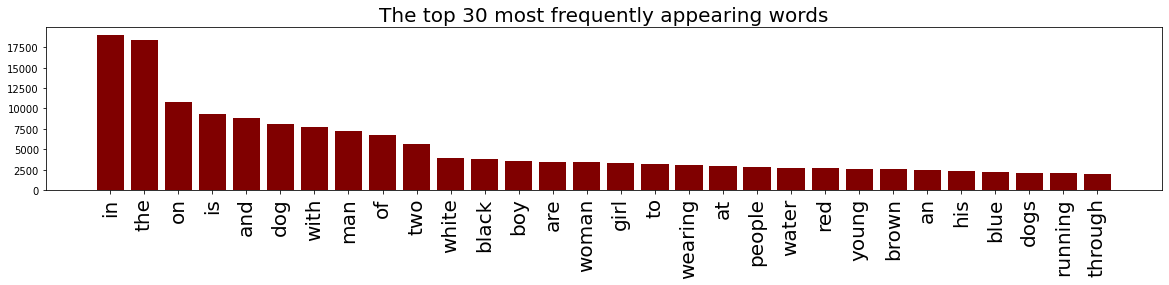

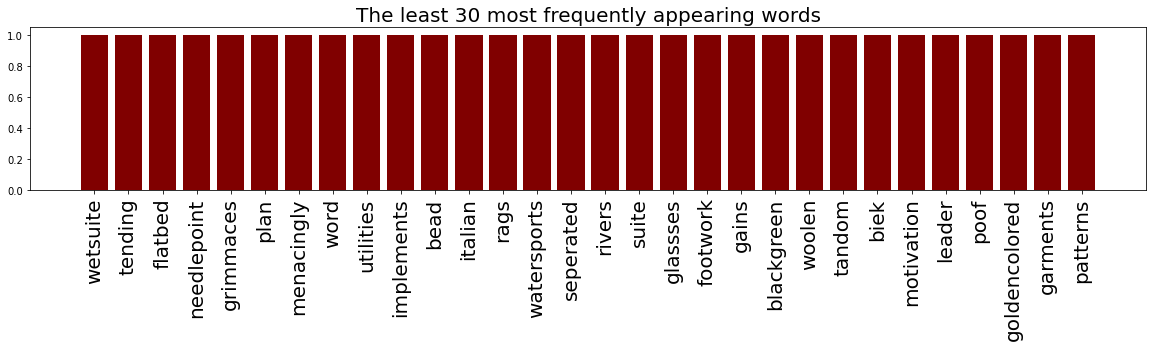

In [ ]:
def plt_hist(allwords, title="The top 30 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(allwords.index,allwords["c"],color="maroon")
    plt.xticks(allwords.index,allwords["w"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
allwords = all_word(int_desc)
#print(allwords.index)
plt_hist(allwords.iloc[:30],
        title="The top 30 most frequently appearing words")
plt_hist(allwords.iloc[-30:],
        title="The least 30 most frequently appearing words")

#Saving descriptions in file

In [ ]:

def save_descriptions(descriptions, filename):
    lines = list()
    for key, val in descriptions.items():
        for desc in val:
            lines.append(key + '  ' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

save_descriptions(int_desc, "descriptions.txt")


In [ ]:
#we have many pre-trained model that have been already trained on large datasets and 
#extract the features from these models and use them for our tasks, namely VGG16,VGG19,ResNet50,Inception V3,Xception
#thses are trained for cnn on imagenet dataset.ImageNet is an image database organized according to the WordNet hierarchy in which
# each node of the hierarchy is depicted by hundreds and thousands of images. Currently we have an average of over five hundred images per node.
# With include_top=False, the model can be used for feature extraction, for example to build an autoencoder or to stack any other model on 
#top of it. Note that input_shape and pooling parameters should only be specified when include_top is False.

# Feature Extractioon using Xception

In [ ]:
img_direc = "/content/drive/My Drive/Dataset/Flickr8k_Dataset/Flicker8k_Dataset"
model = VGG16()#visual geometry group,is an featre extr model from imagenet dataset(images must be classified into one of 1000)
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
features = dict()
for img in listdir(img_direc):
		imgname = img_direc + '/' + img
		image = load_img(imgname,target_size=(224,224))
		image = img_to_array(image)#converts image inot numpy array.
		image = np.expand_dims(image, axis=0)
		image = preprocess_input(image)
		feature = model.predict(image)
		print('>%s' % img)
		features[img] = feature
dump(features, open('features.pkl', 'wb'))


Streaming output truncated to the last 5000 lines.
>3139895886_5a6d495b13.jpg
>3141440149_00becbbb93.jpg
>3141293960_74459f0a24.jpg
>3139876823_859c7d7c23.jpg
>3141613533_595723208d.jpg
>3143574389_8a4048fbe2.jpg
>3143159297_6f2f663ea6.jpg
>3143155555_32b6d24f34.jpg
>3142055158_01b9e4caa4.jpg
>3143765063_a7761b16d3.jpg
>3143982558_9e2d44c155.jpg
>3143953179_1c08c023a5.jpg
>3143978284_ac086be9a3.jpg
>3143980056_7a64a94b58.jpg
>3145967309_b33abe4d84.jpg
>3144705706_391d7b77c7.jpg
>3143991972_7193381aeb.jpg
>3145869775_85dfae43bd.jpg
>3145967019_1a83ebf712.jpg
>314603661_51e05e0e24.jpg
>314685044_da4390728e.jpg
>3146232740_df3da0163b.jpg
>3146355833_1b7fc80210.jpg
>3146937399_8c046b7b1a.jpg
>3146630574_05d9ebbed1.jpg
>3147913471_322ea231d9.jpg
>3148193539_de9dd48fc8.jpg
>3147217787_ed21cd4990.jpg
>3147758035_e8a70818cb.jpg
>3148286846_40ae914172.jpg
>3149038044_c7c94688c6.jpg
>3148571800_c5515e6c3d.jpg
>3148811252_2fa9490a04.jpg
>314904143_5a216a192b.jpg
>3148647065_2d6cd88cf6.jpg
>314980

In [ ]:
print(len(features))

8101


#Loading training images,features,descriptions

In [ ]:
def load_doc(train_img):
	file = open(train_img, 'r')
	data = file.read()
	file.close()
	return data
 
def load_set(filename):
	data = load_doc(filename)
	desc1 = list()
	for line in data.split('\n'):
		if len(line) == 0:
			continue
		desc1.append(line)
	return set(desc1)
 
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = 'start ' + " ".join(image_caption) + ' end'
            descriptions[image].append(desc)
    return descriptions

def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))
	features = {k: all_features[k] for k in dataset}
	return features
#-------------------train images--------------------
train_img = "/content/drive/My Drive/Dataset/Flickr8k_text/Flickr_8k.trainImages.txt"
train_data = load_set(train_img)
print('train dataset: %d' % len(train_data))
print(train_data)
train_descriptions = load_clean_descriptions('descriptions.txt', train_data)
print('train descriptions: train=%d' % len(train_descriptions))
print(train_descriptions)
train_features = load_photo_features('features.pkl', train_data)
print('test photos: train=%d' % len(train_features))
#-------------------------validation images-----------------------------
test_img = "/content/drive/My Drive/Dataset/Flickr8k_text/Flickr_8k.devImages.txt"
test_data = load_set(test_img)
print('test dataset: %d' % len(test_data))
print(test_data)
test_descriptions = load_clean_descriptions('descriptions.txt', test_data)
print('test descriptions: train=%d' % len(test_descriptions))
print(test_descriptions)
test_features = load_photo_features('features.pkl', test_data)
print('train photos: train=%d' % len(test_features))

Output hidden; open in https://colab.research.google.com to view.

#Tokenizing 

In [ ]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    print(desc_list)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    seq = tokenizer.texts_to_sequences(desc_list)[0]
    print(seq)
    return tokenizer
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

['start child in pink dress is climbing up set of stairs in an entry way end', 'start girl going into wooden building end', 'start little girl climbing into wooden playhouse end', 'start little girl climbing the stairs to her playhouse end', 'start little girl in pink dress going into wooden cabin end', 'start black dog and spotted dog are fighting end', 'start black dog and tricolored dog playing with each other on the road end', 'start black dog and white dog with brown spots are staring at each other in the street end', 'start two dogs of different breeds looking at each other on the road end', 'start two dogs on pavement moving toward each other end', 'start little girl covered in paint sits in front of painted rainbow with her hands in bowl end', 'start little girl is sitting in front of large painted rainbow end', 'start small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it end', 'start there is girl with pigtails sitting in front of rainbow 

7577

# Maximum Length of Descriptions

In [ ]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(int_desc)
max_length

32

# Data Generator

In [ ]:
#create input-output sequence pairs from the image description.
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)
#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, 32))
a.shape, b.shape, c.shape

((47, 4096), (47, 32), (47, 7577))

# CNN-RNN model

In [ ]:
from keras.models import Model, load_model
def define_model(vocab_size, max_length):
		input1 = Input(shape=(4096,))
		ip_img = Dropout(0.4)(input1)
		ip_img_dns = Dense(256, activation='relu')(ip_img)
	# sequence model
		input2 = Input(shape=(max_length,))
		ip_txt_emb = Embedding(vocab_size, 256, mask_zero=True)(input2)
		ip_txt = Dropout(0.4)(ip_txt_emb)
		ip_txt_lstm = LSTM(256)(ip_txt)
	# decoder model
		decoder = add([ip_img_dns,ip_txt_lstm])
		decoder = Dense(256, activation='relu')(decoder)
		output = Dense(vocab_size, activation='softmax')(decoder)
	# tie it together [image, seq] [word]
		model1 = Model(inputs=[input1, input2], outputs=output)
		model1.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
		plot_model(model1, to_file='model.png', show_shapes=True)
		model1.summary()
		return model1;

In [ ]:
model2 = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
for i in range(epochs):
    train_gen = data_generator(train_descriptions, train_features, tokenizer, max_length)
    test_gen = data_generator(test_descriptions, test_features, tokenizer, max_length)
    model2.fit_generator(train_gen, epochs=1, steps_per_epoch= steps, verbose=1,validation_data=(test_gen),validation_steps=steps)
    model2.save("model_" + str(i) + ".h5")

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 256)      1939712     input_10[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_9[0][0]                    
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
6000/6000 [==============================] - 488s 81ms/step - loss: 4.6213 - val_loss: 3.5805
Epoch 1/1
6000/6000 [==============================] - 483s 80ms/step - loss: 3.8529 - val_loss: 3.3579
Epoch 1/1
6000/6000 [==============================] - 481s 80ms/step - loss: 3.5875 - val_loss: 3.3662
Epoch 1/1
1821/6000 [========>.....................] - ETA: 4:42 - loss: 3.4306

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
def extract_features(filename):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    image = load_img(filename,target_size=(224,224))
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature;
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start '
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 34
tokenizer = load(open("/content/tokenizer.pkl"))
model = load_model('/content/model_9.h5')
photo = extract_features("/content/drive/My Drive/Dataset/Flickr8k_Dataset/Flicker8k_Dataset/3662909101_21b9e59a3e.jpg")
img = Image.open("/content/drive/My Drive/Dataset/Flickr8k_Dataset/Flicker8k_Dataset/3662909101_21b9e59a3e.jpg")
description = generate_desc(model, tokenizer, photo, max_length)
print("\n")
print(description)
plt.imshow(img)

UnicodeDecodeError: ignored